In [8]:
import os
import glob
import json

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from library.sb_utils import save_file

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import leafmap
from IPython.display import Image

# Exploration of Electric usage data

In [2]:
# Load the data from the Data Wrangling step
%store -r electric_res

## Geospatial exploration

We use the Leafmap package to visualize the zip codes present in the data.

To do this, we need some data on the boundaries of the zip codes:

CA zip codes geojson source: https://github.com/OpenDataDE/State-zip-code-GeoJSON

This is a large file, so we will select from it only the zip codes that are present in our dataset.

In [3]:
# Create a GeoJSON dict with only the subset of zipcodes needed.

# Load California Zip codes geojson
with open('./data/ca_california_zip_codes_geo.min.json', 'r') as f:
    ca_zip_json = json.load(f)

elec_zip = electric_res['ZipCode'].unique()

feature_list = []
for feature in ca_zip_json['features']:
    if feature['properties']['ZCTA5CE10'] in elec_zip:
        feature_list.append(feature)

elec_geojson = {'type': 'FeatureCollection', 'features': feature_list}

In [4]:
# number of zip code features in full CA geojson file

len(ca_zip_json['features'])

1769

In [5]:
# number of unique zip codes in our electric dataset

len(electric_res['ZipCode'].unique())

727

In [6]:
# number of zip codes matched

len(elec_geojson['features'])

715

We used string matching to subset the zip code geojson data, keeping only the zip codes present in our electric dataset. We lost a few zip codes along the way. This could be due to data quality issues or incompleteness of the geojson file. We will only be using a fraction of the total zip codes, so it probably won't cause any issues. We will note this discrepancy here for future follow up if needed.

Next we use the Leafmap package to visualize the zip codes.

In [7]:
# render all electric data zip codes

m1 = leafmap.Map(height="800px", width="400px")
m1 = leafmap.Map(center=(37,-120), zoom=6)
in_geojson = elec_geojson
style = {'fillOpacity': 0.5}
m1.add_geojson(in_geojson, layer_name='Zip codes', style=style, fill_colors=['red', 'yellow', 'green', 'orange'])
m1

Map(center=[37, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

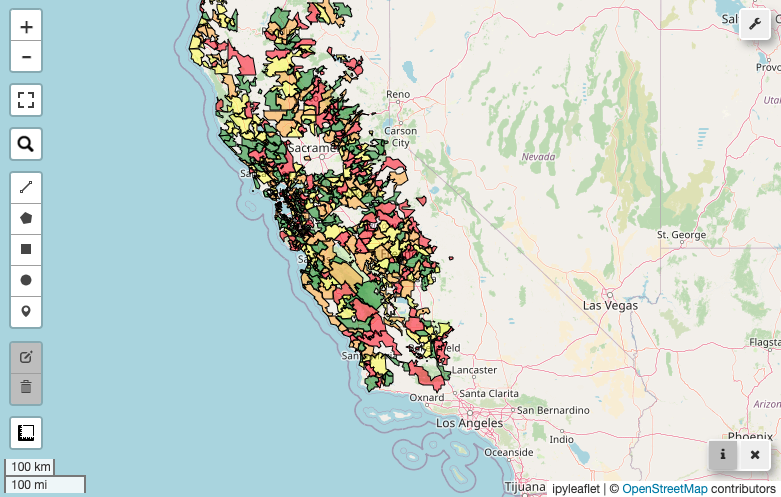

In [11]:
# Here is a static image, in case the widget above doesn't load.

Image(filename='images/zip_codes_pge.png') 

We see that the zip codes cover most of northern California as expected. The gaps in coverage are due to a couple of factors: (a) some zip codes have few or no residential customers and have been filtered out, (b) some areas are serviced by other companies (i.e. Sacramento).

Let's zoom in on the Bay Area:

In [12]:
# render all electric data zip codes

m2 = leafmap.Map(height="800px", width="400px")
m2 = leafmap.Map(center=(37.6,-122), zoom=8)
in_geojson = elec_geojson
style = {'fillOpacity': 0.5}
m2.add_geojson(in_geojson, layer_name='Zip codes', style=style, fill_colors=['red', 'yellow', 'green', 'orange'])
m2

Map(center=[37.6, -122], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

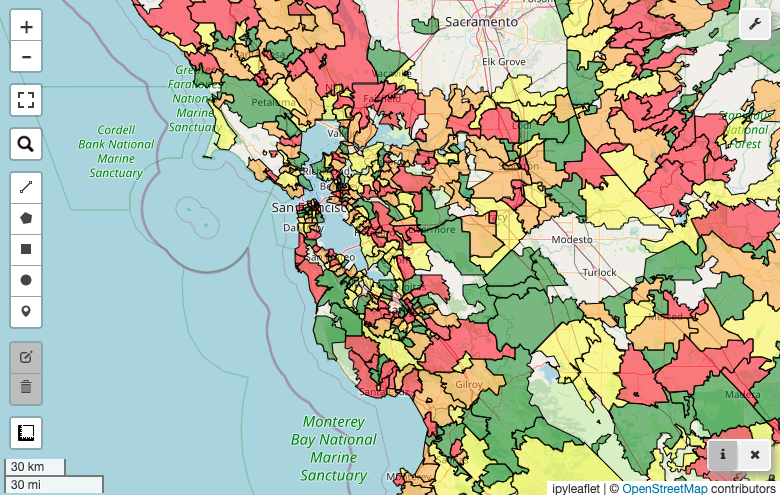

In [13]:
# Here is a static image, in case the widget above doesn't load.

Image(filename='images/zip_codes_bayarea.png') 

Looks like we have good geographic coverage of the Bay Area.

One thing we can see when examining this map is that the zip code associated with our weather data (94062) covers a large area that includes part of Redwood City as well as a large swathe of the Santa Cruz mountains. Due to the varied microclimates of the Bay Area, the weather station data may not match the actual conditions for many electric customers in this zip code. The adjacent zip code 94061 is close to the Redwood City weather station and much more compact, making it a better candidate for modeling. Let's check if it has enough residential electric customers:

In [14]:
electric_res.loc[electric_res['ZipCode'] == '94061'].loc[electric_res['Date'] == '2023-09-01']['TotalCustomers']

22318    13807
Name: TotalCustomers, dtype: int64

In [15]:
electric_res.loc[electric_res['ZipCode'] == '94062'].loc[electric_res['Date'] == '2023-09-01']['TotalCustomers']

22321    9933
Name: TotalCustomers, dtype: int64

Zip code 94061 actually has more residential electric customers than 94062, despite it's smaller geographical extent. Let's use this zip code for our modelling.

## Time series examination

We will examine the time series data for a single zip code of choice, 94061.

In [16]:
# select single time series for Redwood City, CA

electric_rwc = electric_res.loc[electric_res['ZipCode'] == '94061']

In [17]:
# summary statistics

electric_rwc.describe()

,Month,Year,TotalCustomers,TotalkWh,AveragekWh,Day,Date
count,139.000000,139.000000,139.000000,1.390000e+02,139.000000,139.0,139
mean,6.388489,2017.604317,13437.316547,5.594497e+06,416.395683,1.0,2018-01-19 15:42:44.028776960
min,1.000000,2013.000000,13231.000000,4.556581e+06,339.000000,1.0,2013-01-01 00:00:00
25%,3.000000,2015.000000,13358.000000,5.167116e+06,386.000000,1.0,2015-02-15 00:00:00
50%,6.000000,2017.000000,13422.000000,5.459871e+06,406.000000,1.0,2017-12-01 00:00:00
75%,9.000000,2020.000000,13469.500000,5.847734e+06,433.000000,1.0,2020-10-16 12:00:00
max,12.000000,2023.000000,13807.000000,7.510232e+06,561.000000,1.0,2023-09-01 00:00:00
std,3.456795,3.179688,125.533703,6.369721e+05,47.746404,0.0,NaN


In [18]:
# check for missing data

electric_rwc.isnull().sum()

ZipCode           0
Month             0
Year              0
CustomerClass     0
Combined          0
TotalCustomers    0
TotalkWh          0
AveragekWh        0
Day               0
Date              0
DateMY            0
dtype: int64

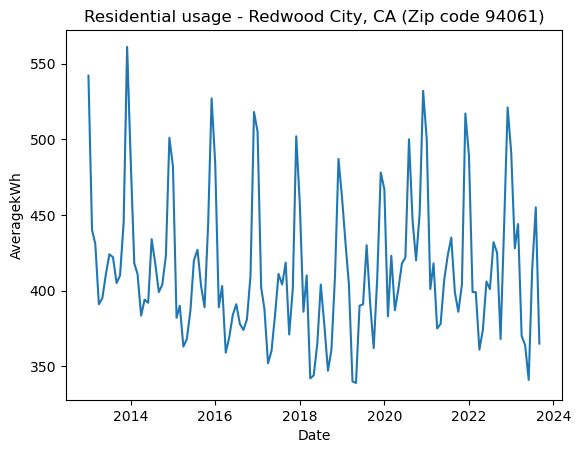

In [19]:
sns.lineplot(data=electric_rwc, x='Date', y='AveragekWh')
plt.title('Residential usage - Redwood City, CA (Zip code 94061)')
plt.show()

This time series looks good. There is a clear seasonal trend and no obvious outliers.

# Exploration of Weather data

In [20]:
# load and rename weather data

%store -r weather_94062

weather_rwc = weather_94062

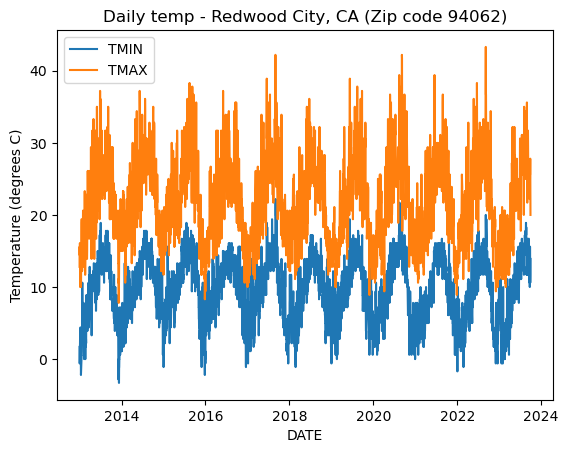

In [21]:
sns.lineplot(data=weather_rwc, hue_order=['TMIN','TMAX'], dashes=False)
plt.title('Daily temp - Redwood City, CA (Zip code 94062)')
plt.ylabel('Temperature (degrees C)')
plt.show()

In [22]:
# summary statistics

weather_rwc.describe()

,TMAX,TMIN
count,3923.000000,3923.000000
mean,21.886439,9.536222
std,5.844846,4.382710
min,7.800000,-3.300000
25%,17.200000,6.100000
50%,21.700000,10.000000
75%,26.100000,12.800000
max,43.300000,22.200000


In [23]:
# check for missing data

weather_rwc.isnull().sum()

TMAX    0
TMIN    0
dtype: int64

## Explore long time scale weather trend

Let's see if there is a long term warming trend in the data. We'll go back to the full weather time series.

In [24]:
%store -r df_weather

In [25]:
weather_long = (df_weather['1930-10-01':][['TMAX', 'TMIN']]/10)

In [26]:
weather_long = weather_long.interpolate()

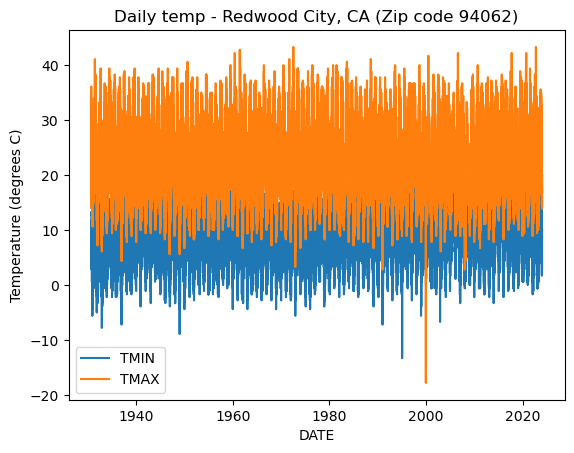

In [27]:
sns.lineplot(data=weather_long, hue_order=['TMIN','TMAX'], dashes=False)
plt.title('Daily temp - Redwood City, CA (Zip code 94062)')
plt.ylabel('Temperature (degrees C)')
plt.show()

It's hard to see any long term trend through the seasonal variation. Let's smooth the data with a rolling average. We'll focus on the temperature maximum.

In [28]:
tmax_smooth10 = weather_long['TMAX'].rolling(365*10).mean()

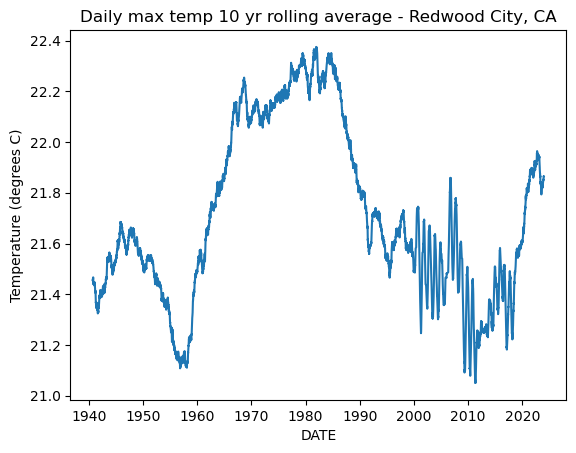

In [29]:
sns.lineplot(data=tmax_smooth10)
plt.title('Daily max temp 10 yr rolling average - Redwood City, CA')
plt.ylabel('Temperature (degrees C)')
plt.show()

In [30]:
tmax_smooth5 = weather_long['TMAX'].rolling(365*5).mean()

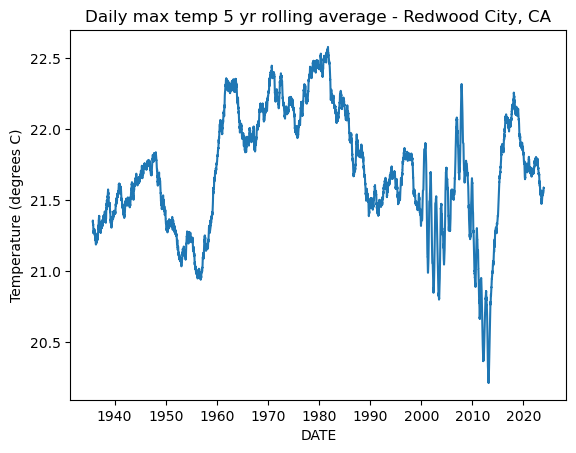

In [31]:
sns.lineplot(data=tmax_smooth5)
plt.title('Daily max temp 5 yr rolling average - Redwood City, CA')
plt.ylabel('Temperature (degrees C)')
plt.show()

We see lots of variation on a decadal timescale, with perhaps a slight warming trend.

## Save the data

For input into Pre-processing

In [32]:
# store the data

%store electric_rwc
%store weather_rwc

Stored 'electric_rwc' (DataFrame)
Stored 'weather_rwc' (DataFrame)
